<div class="alert alert-info">
<h1><center> HEART DISEASE PREDICTION USING LOGISTIC REGRESSION.</center></h1>



## Introduction

According to World Health Organization an estimated 17.9 million people died from CVDs in 2016. Half the deaths in the United States and other developed countries are due to cardio vascular diseases. The early prognosis of cardiovascular diseases can aid in making decisions on lifestyle changes in high risk patients and in turn reduce the complications. This research intends to pinpoint the most relevant/risk factors of heart disease as well as predict the overall risk using logistic regression.


In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix
import matplotlib.mlab as mlab
%matplotlib inline

## Data Preparation

### Source:

The dataset is publically available on the Kaggle website, and it is from an ongoing ongoing cardiovascular study on residents of the town of Framingham, Massachusetts.  The classification goal is to predict whether the patient has 10-year risk of future coronary heart disease (CHD).The dataset provides the patients’ information. It includes over 4,000 records and 15 attributes.

In [2]:
heart_df=pd.read_csv('framingham.csv')
heart_df.drop(['education'],axis=1,inplace=True)
heart_df.head()

,male,age,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


### Variables :

Each attribute is a potential risk factor. There are both demographic, behavioural and medical risk factors.

 - **Demographic:**
    -  sex: male or female;(Nominal)

    -  age: age of the patient;(Continuous - Although the recorded ages have been truncated to whole numbers, the concept of age is continuous)


 - **Behavioural**

    -  currentSmoker: whether or not the patient is a current smoker (Nominal)

    -  cigsPerDay: the number of cigarettes that the person smoked on average in one day.(can be considered continuous as one can have any number of cigarretts, even half a cigarette.)

 - **Medical( history):**

    -  BPMeds: whether or not the patient was on blood pressure medication (Nominal)

    -  prevalentStroke: whether or not the patient had previously had a stroke (Nominal)

    -  prevalentHyp: whether or not the patient was hypertensive (Nominal)

    -  diabetes: whether or not the patient had diabetes (Nominal)

 - **Medical(current):** 

    -  totChol: total cholesterol level (Continuous)

    -  sysBP: systolic blood pressure (Continuous)

    -  diaBP: diastolic blood pressure (Continuous)

    -  BMI: Body Mass Index (Continuous)

    -  heartRate: heart rate (Continuous - In medical research, variables such as heart rate though in fact discrete, yet are considered continuous because of large number of possible values.)

    -  glucose: glucose level (Continuous)


 - **Predict variable (desired target):**

    -  10 year risk of coronary heart disease CHD (binary: “1”, means “Yes”, “0” means “No”)


In [3]:
heart_df.rename(columns={'male':'Sex_male'},inplace=True)

### Missing values

In [4]:
heart_df.isnull().sum()

Sex_male             0
age                  0
currentSmoker        0
cigsPerDay          29
BPMeds              53
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             50
sysBP                0
diaBP                0
BMI                 19
heartRate            1
glucose            388
TenYearCHD           0
dtype: int64

In [5]:
count=0
for i in heart_df.isnull().sum(axis=1):
    if i>0:
        count=count+1
print('Total number of rows with missing values is ', count)
print('since it is only',round((count/len(heart_df.index))*100), 'percent of the entire dataset the rows with missing values are excluded.')

Total number of rows with missing values is  489
since it is only 12 percent of the entire dataset the rows with missing values are excluded.


In [6]:
heart_df.dropna(axis=0,inplace=True)

## Exploratory Analysis

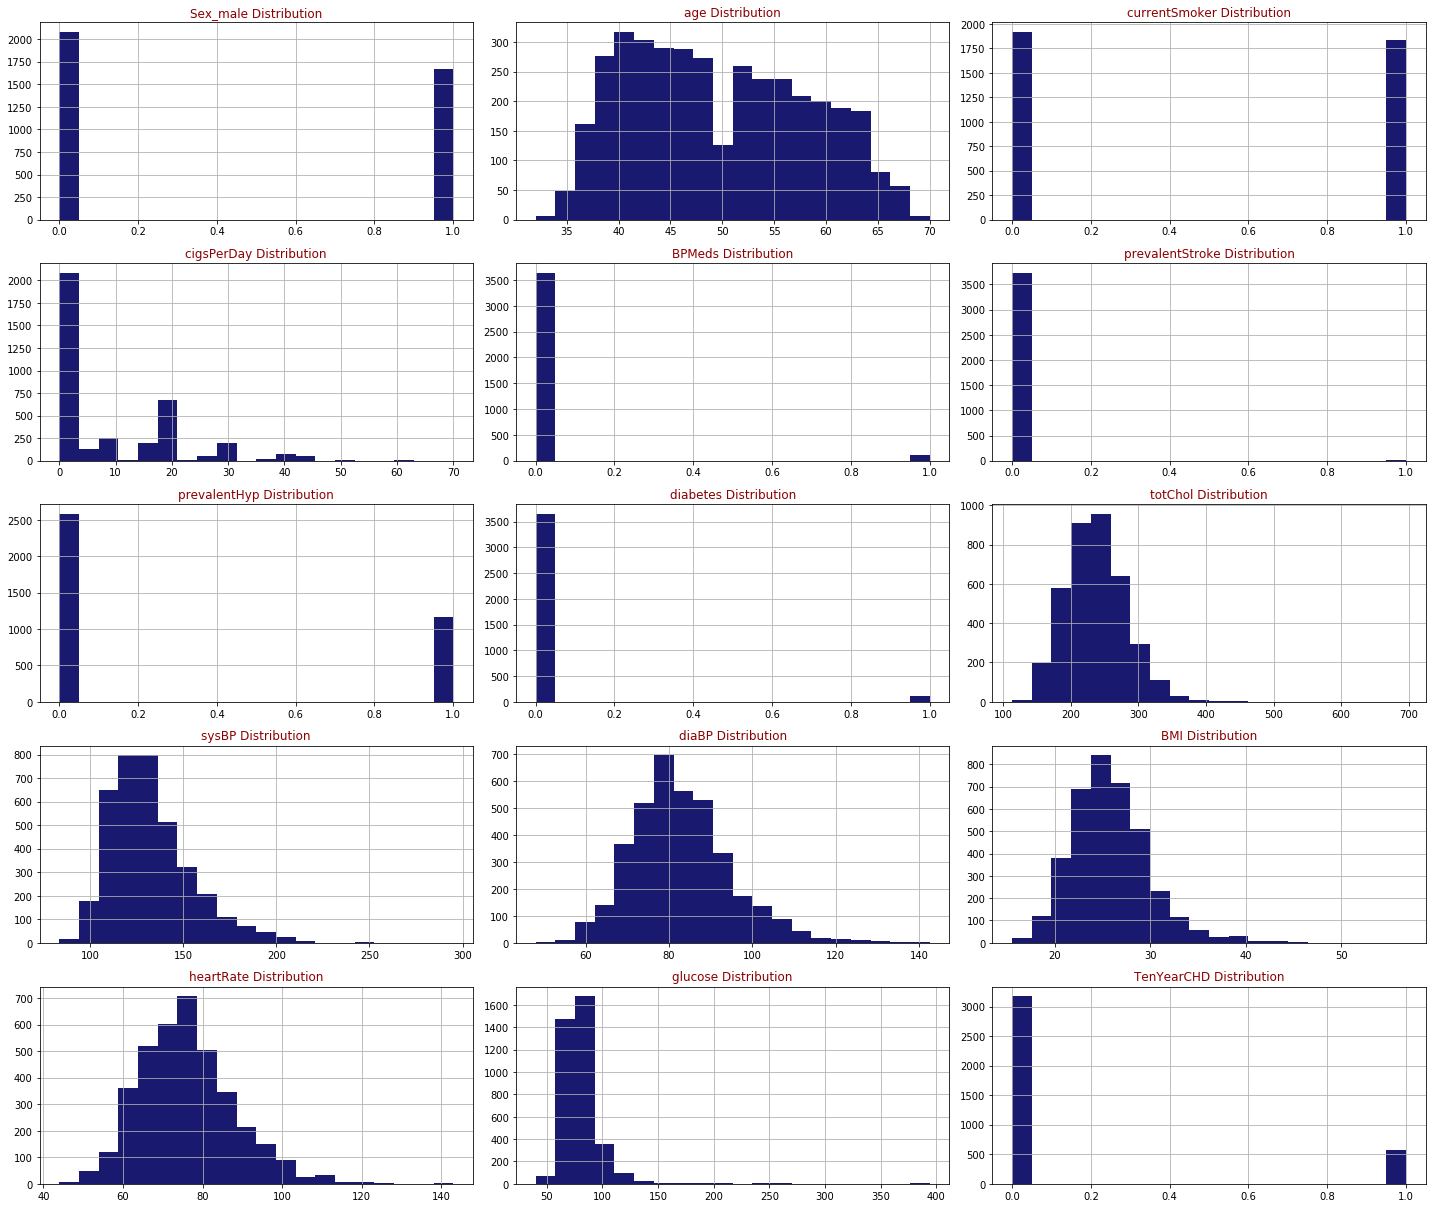

In [7]:
def draw_histograms(dataframe, features, rows, cols):
    fig=plt.figure(figsize=(20,20))
    for i, feature in enumerate(features):
        ax=fig.add_subplot(rows,cols,i+1)
        dataframe[feature].hist(bins=20,ax=ax,facecolor='midnightblue')
        ax.set_title(feature+" Distribution",color='DarkRed')
        
    fig.tight_layout()  
    plt.show()
draw_histograms(heart_df,heart_df.columns,6,3)

In [8]:
heart_df.TenYearCHD.value_counts()

0    3179
1     572
Name: TenYearCHD, dtype: int64

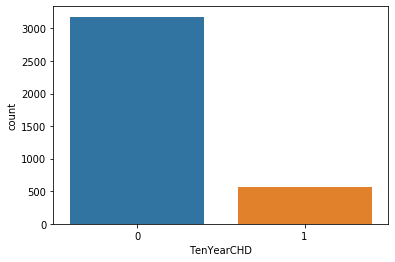

In [9]:
sn.countplot(x='TenYearCHD',data=heart_df)

There are 3179 patents with no heart disease and 572 patients with risk of heart disease. The data is imbalanced and an approach to reduce it such as imbalanced learn might help improve the model. However it is not attempted in this project.

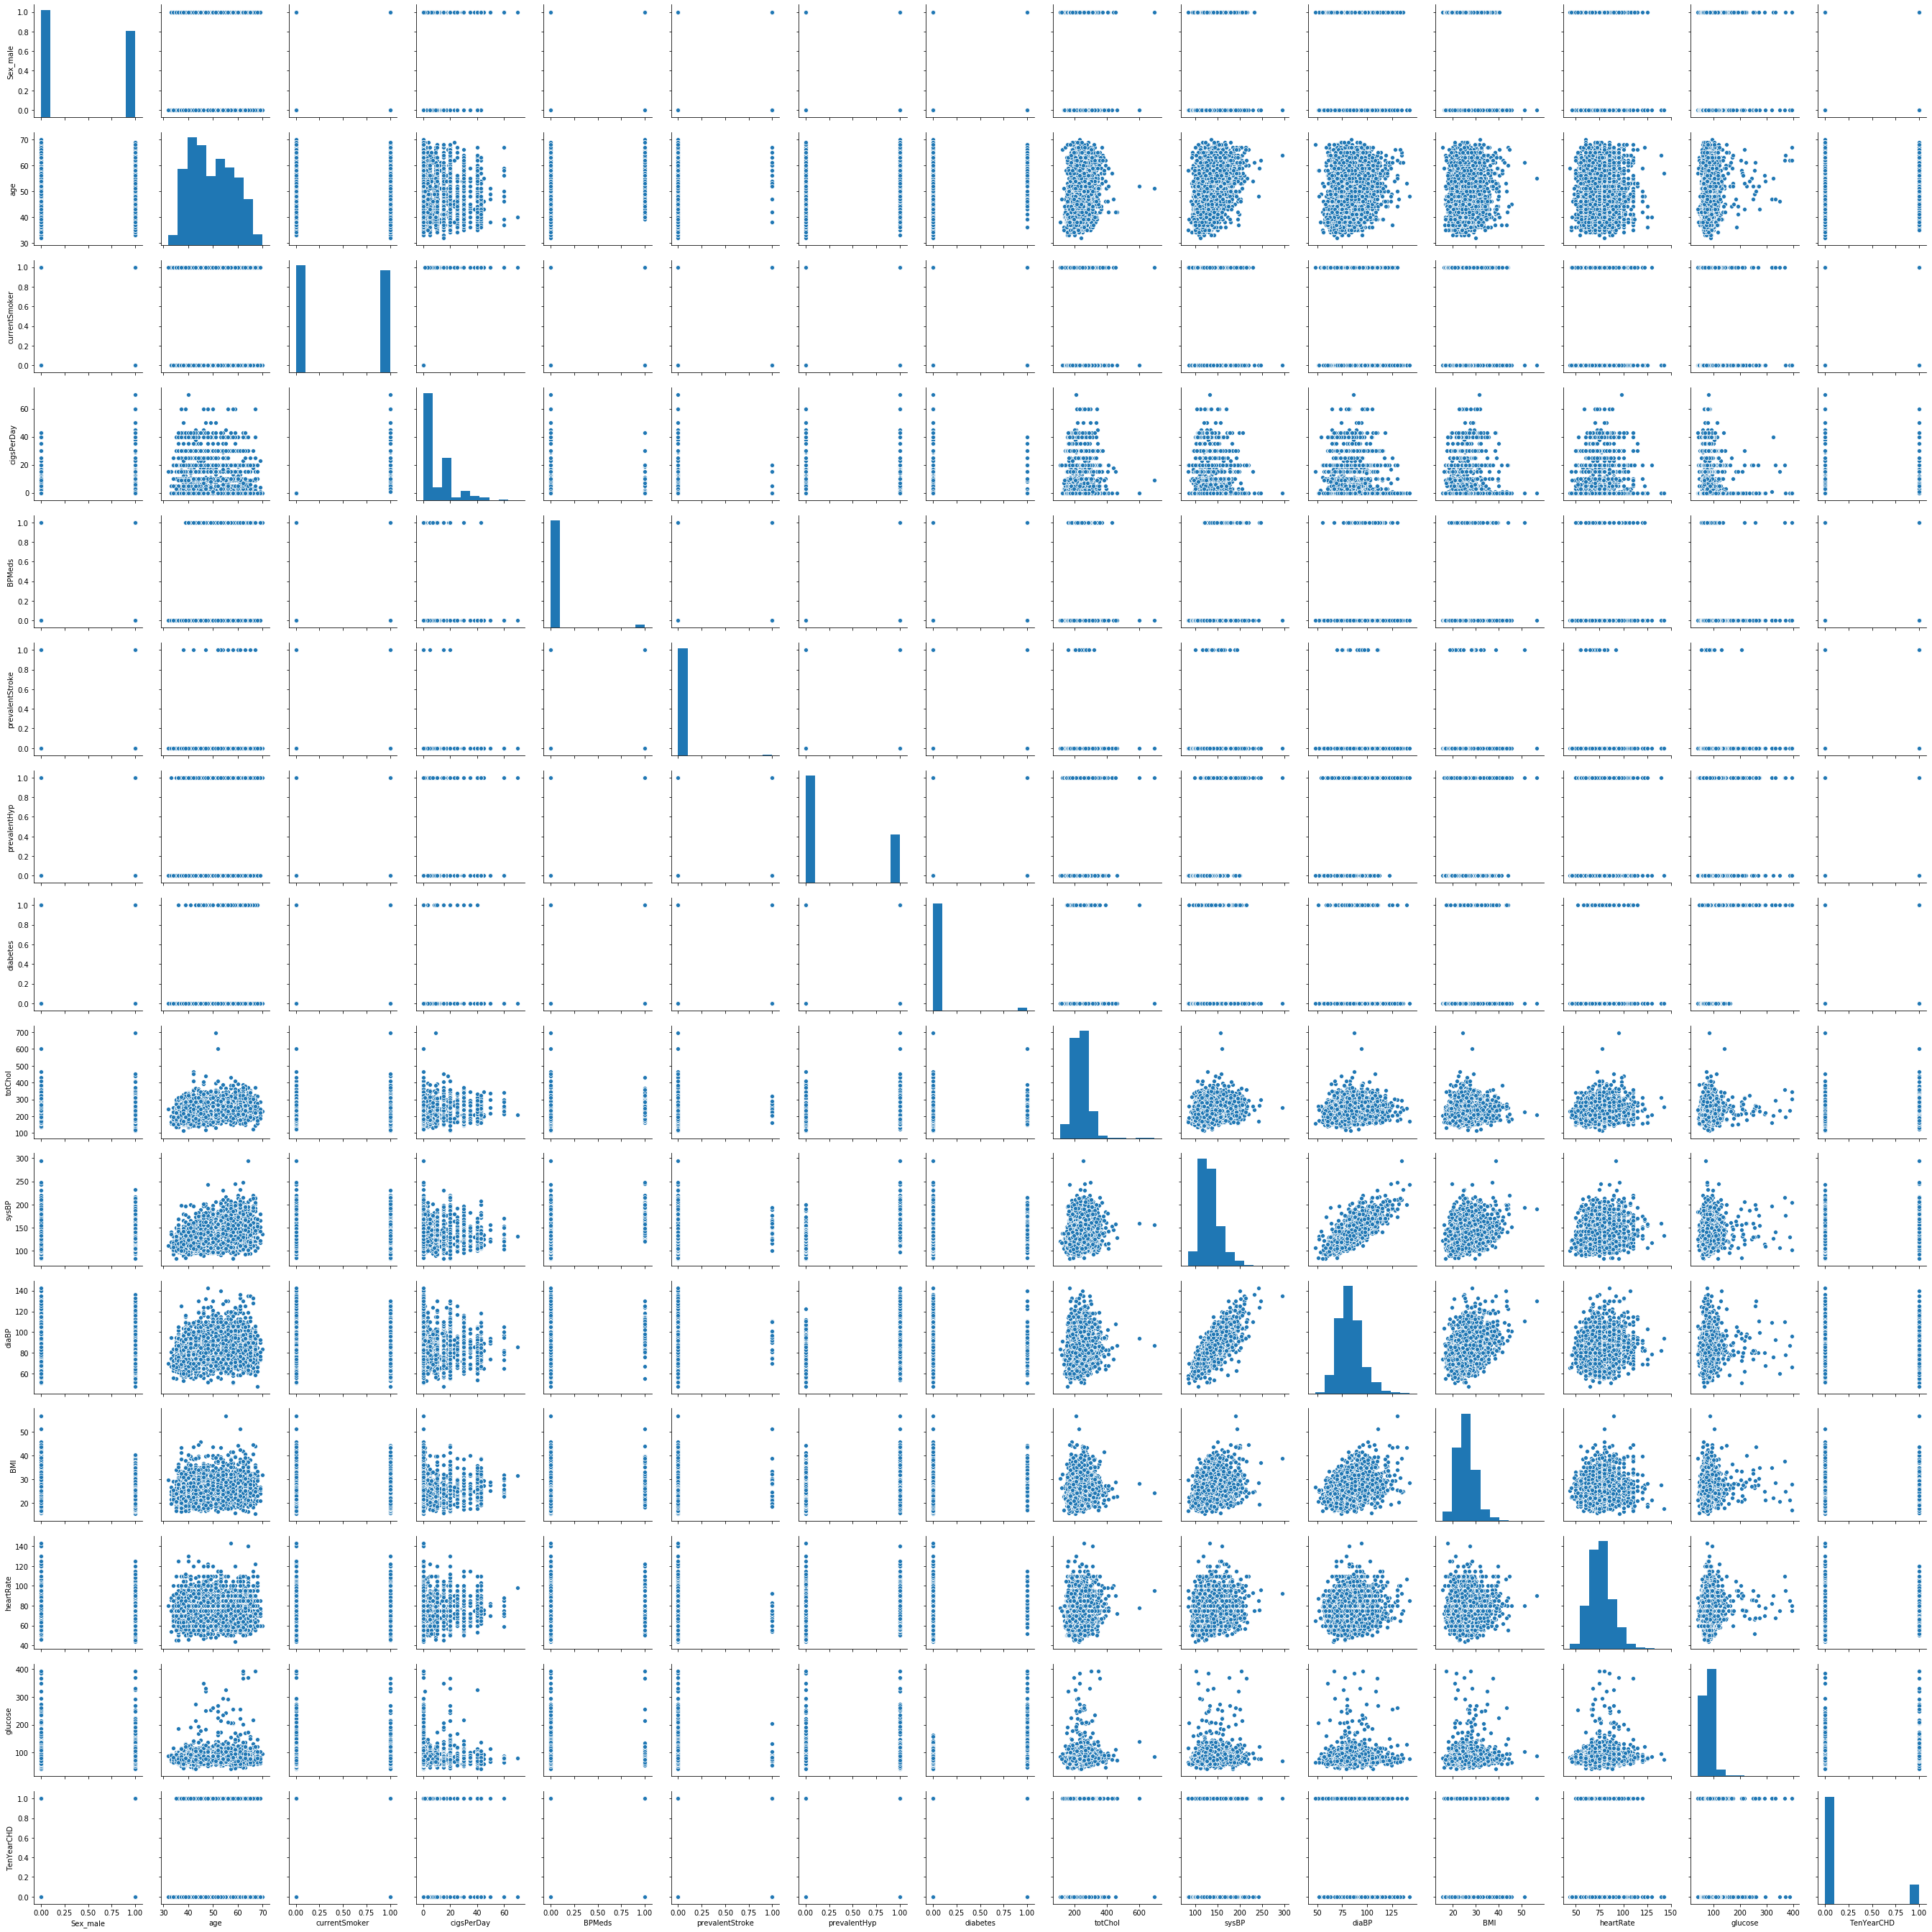

In [10]:
sn.pairplot(data=heart_df)

In [11]:
heart_df.describe()

,Sex_male,age,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
count,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000
mean,0.445215,49.573447,0.488403,9.008531,0.030392,0.005599,0.311917,0.027193,236.928019,132.368435,82.938550,25.808288,75.704079,81.880032,0.152493
std,0.497056,8.570204,0.499932,11.925097,0.171686,0.074623,0.463338,0.162666,44.611594,22.046522,11.932779,4.065599,11.956382,23.882233,0.359546
min,0.000000,32.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,113.000000,83.500000,48.000000,15.540000,44.000000,40.000000,0.000000
25%,0.000000,42.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,117.000000,75.000000,23.085000,68.000000,71.000000,0.000000
50%,0.000000,49.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,234.000000,128.000000,82.000000,25.410000,75.000000,78.000000,0.000000
75%,1.000000,56.000000,1.000000,20.000000,0.000000,0.000000,1.000000,0.000000,264.000000,144.000000,90.000000,28.060000,82.000000,87.000000,0.000000
max,1.000000,70.000000,1.000000,70.000000,1.000000,1.000000,1.000000,1.000000,696.000000,295.000000,142.500000,56.800000,143.000000,394.000000,1.000000


## Logistic Regression

Logistic regression is a type of regression analysis in statistics used for prediction of outcome of a categorical dependent variable from a set of predictor or independent variables. In logistic regression the dependent variable is always binary. Logistic regression is mainly used to for prediction and also calculating the probability of success. 

In [12]:
from statsmodels.tools import add_constant as add_constant
heart_df_constant = add_constant(heart_df)
heart_df_constant.head()

//anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


,const,Sex_male,age,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1.0,1,39,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,1.0,0,46,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1.0,1,48,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,1.0,0,61,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,1.0,0,46,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [13]:

cols=heart_df_constant.columns[:-1]
model=sm.Logit(heart_df.TenYearCHD,heart_df_constant[cols])
result=model.fit()
result.summary()


Optimization terminated successfully.
         Current function value: 0.377036
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             TenYearCHD   No. Observations:                 3751
Model:                          Logit   Df Residuals:                     3736
Method:                           MLE   Df Model:                           14
Date:                Mon, 25 Nov 2019   Pseudo R-squ.:                  0.1170
Time:                        12:05:01   Log-Likelihood:                -1414.3
converged:                       True   LL-Null:                       -1601.7
Covariance Type:            nonrobust   LLR p-value:                 2.439e-71
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -8.6532      0.687    -12.589      0.000     -10.000      -7.306
Sex_male            0.5742      0.107      5.345      0.000       0.364       0.785
age                 0.0641      0.007      9.799      0.000       0.051       0.077
currentSmoker       0.0739      0.155      0.478      0.633      -0.229       0.377
cigsPerDay          0.0184      0.006      3.000      0.003       0.006       0.030
BPMeds              0.1448      0.232      0.623      0.533      -0.310       0.600
prevalentStroke     0.7193      0.489      1.471      0.141      -0.239       1.678
prevalentHyp        0.2142      0.136      1.571      0.116      -0.053       0.481
diabetes            0.0022      0.312      0.007      0.994      -0.610       0.614
totChol             0.0023      0.001      2.081      0.037       0.000       0.004
sysBP               0.0154      0.004      4.082      0.000       0.008       0.023
diaBP              -0.0040      0.006     -0.623      0.533      -0.016       0.009
BMI                 0.0103      0.013      0.827      0.408      -0.014       0.035
heartRate          -0.0023      0.004     -0.549      0.583      -0.010       0.006
glucose             0.0076      0.002      3.409      0.001       0.003       0.012
===================================================================================
"""

The results above show some of the attributes with P value higher than the preferred alpha(5%) and thereby showing  low statistically significant relationship with the probability of heart disease. Backward elemination approach is used here to remove those attributes with highest Pvalue one at a time follwed by  running the regression repeatedly until all attributes have P Values less than 0.05.



### Feature Selection: Backward elemination (P-value approach)

In [14]:
def back_feature_elem (data_frame,dep_var,col_list):
    """ Takes in the dataframe, the dependent variable and a list of column names, runs the regression repeatedly eleminating feature with the highest
    P-value above alpha one at a time and returns the regression summary with all p-values below alpha"""

    while len(col_list)>0 :
        model=sm.Logit(dep_var,data_frame[col_list])
        result=model.fit(disp=0)
        largest_pvalue=round(result.pvalues,3).nlargest(1)
        if largest_pvalue[0]<(0.05):
            return result
            break
        else:
            col_list=col_list.drop(largest_pvalue.index)

result=back_feature_elem(heart_df_constant,heart_df.TenYearCHD,cols)

In [15]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             TenYearCHD   No. Observations:                 3751
Model:                          Logit   Df Residuals:                     3744
Method:                           MLE   Df Model:                            6
Date:                Mon, 25 Nov 2019   Pseudo R-squ.:                  0.1149
Time:                        12:05:02   Log-Likelihood:                -1417.7
converged:                       True   LL-Null:                       -1601.7
Covariance Type:            nonrobust   LLR p-value:                 2.127e-76
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -9.1264      0.468    -19.504      0.000     -10.043      -8.209
Sex_male       0.5815      0.105      5.524      0.000       0.375       0.788
age            0.0655      0.006     10.343      0.000       0.053       0.078
cigsPerDay     0.0197      0.004      4.805      0.000       0.012       0.028
totChol        0.0023      0.001      2.106      0.035       0.000       0.004
sysBP          0.0174      0.002      8.162      0.000       0.013       0.022
glucose        0.0076      0.002      4.574      0.000       0.004       0.011
==============================================================================
"""

#### Logistic regression equation

$$P=\hspace{.2cm}e^{\beta_0 + \beta_1 X_1}\hspace{.2cm}/\hspace{.2cm}1+e^{\beta_0 +\beta_1 X_1}$$

When all features plugged in:

$$logit(p) = log(p/(1-p))=\beta_0 +\beta_1\hspace{.1cm} *\hspace{.2cm} Sexmale\hspace{.2cm}+\beta_2\hspace{.1cm} * \hspace{.1cm}age\hspace{.2cm}+\hspace{.2cm}\beta_3\hspace{.1cm} *\hspace{.1cm} cigsPerDay\hspace{.2cm}+\hspace{.2cm}\beta_4 \hspace{.1cm}*\hspace{.1cm} totChol\hspace{.2cm}+\hspace{.2cm}\beta_5\hspace{.1cm} *\hspace{.1cm} sysBP\hspace{.2cm}+\hspace{.2cm}\beta_6\hspace{.1cm} *\hspace{.1cm} glucose\hspace{.2cm}$$



## Interpreting the results: Odds Ratio, Confidence Intervals and Pvalues

In [16]:
params = np.exp(result.params)
conf = np.exp(result.conf_int())
conf['OR'] = params
pvalue=round(result.pvalues,3)
conf['pvalue']=pvalue
conf.columns = ['CI 95%(2.5%)', 'CI 95%(97.5%)', 'Odds Ratio','pvalue']
print ((conf))


            CI 95%(2.5%)  CI 95%(97.5%)  Odds Ratio  pvalue
const           0.000043       0.000272    0.000109   0.000
Sex_male        1.455242       2.198536    1.788687   0.000
age             1.054483       1.080969    1.067644   0.000
cigsPerDay      1.011733       1.028128    1.019897   0.000
totChol         1.000158       1.004394    1.002273   0.035
sysBP           1.013292       1.021784    1.017529   0.000
glucose         1.004346       1.010898    1.007617   0.000


 - **This fitted model shows that, holding all other features constant, the odds of getting diagnosed with heart disease for males (sex_male = 1)over that of  females (sex_male = 0) is exp(0.5815) = 1.788687. In terms of percent change, we can say that the odds for males are 78.8% higher than the odds for females.**
<br>
<br>

 - **The coefficient for age says that, holding all others constant, we will see 7% increase in the odds of getting diagnosed with CDH for a one year increase in age since exp(0.0655) = 1.067644.**
<br>
<br>
 - **Similarly , with every extra cigarette one smokes thers is a 2% increase in the odds of CDH.** 
<br>
<br>
 - **For Total cholosterol level and glucose level there is no significant change.**
<br>
<br>
 - **There is a 1.7% increase in odds for every unit increase in systolic Blood Pressure.**


### Splitting data to train and test split

In [17]:
import sklearn
new_features=heart_df[['age','Sex_male','cigsPerDay','totChol','sysBP','glucose','TenYearCHD']]
x=new_features.iloc[:,:-1]
y=new_features.iloc[:,-1]
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.20,random_state=5)

In [18]:
from sklearn.linear_model import LogisticRegression
logreg=LogisticRegression()
logreg.fit(x_train,y_train)
y_pred=logreg.predict(x_test)

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


## Model Evaluation

### Model accuracy

In [19]:
sklearn.metrics.accuracy_score(y_test,y_pred)

0.881491344873502

####  Accuracy of the model is 0.88

### Confusion matrix

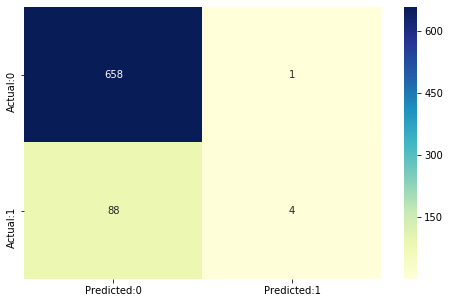

In [20]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,y_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sn.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")

The confusion matrix shows 658+4 = 662 correct predictions and 88+1= 89 incorrect ones.

**True Positives:**  4

**True Negatives:**  658

**False Positives:** 1 (*Type I error*)

**False Negatives:** 88 ( *Type II error*)

In [21]:
TN=cm[0,0]
TP=cm[1,1]
FN=cm[1,0]
FP=cm[0,1]
sensitivity=TP/float(TP+FN)
specificity=TN/float(TN+FP)

### Model Evaluation - Statistics

In [22]:
print('The acuuracy of the model = TP+TN/(TP+TN+FP+FN) = ',(TP+TN)/float(TP+TN+FP+FN),'\n',

'The Missclassification = 1-Accuracy = ',1-((TP+TN)/float(TP+TN+FP+FN)),'\n',

'Sensitivity or True Positive Rate = TP/(TP+FN) = ',TP/float(TP+FN),'\n',

'Specificity or True Negative Rate = TN/(TN+FP) = ',TN/float(TN+FP),'\n',

'Positive Predictive value = TP/(TP+FP) = ',TP/float(TP+FP),'\n',

'Negative predictive Value = TN/(TN+FN) = ',TN/float(TN+FN),'\n',

'Positive Likelihood Ratio = Sensitivity/(1-Specificity) = ',sensitivity/(1-specificity),'\n',

'Negative likelihood Ratio = (1-Sensitivity)/Specificity = ',(1-sensitivity)/specificity)


The acuuracy of the model = TP+TN/(TP+TN+FP+FN) =  0.881491344873502 
 The Missclassification = 1-Accuracy =  0.118508655126498 
 Sensitivity or True Positive Rate = TP/(TP+FN) =  0.043478260869565216 
 Specificity or True Negative Rate = TN/(TN+FP) =  0.9984825493171472 
 Positive Predictive value = TP/(TP+FP) =  0.8 
 Negative predictive Value = TN/(TN+FN) =  0.8820375335120644 
 Positive Likelihood Ratio = Sensitivity/(1-Specificity) =  28.65217391304351 
 Negative likelihood Ratio = (1-Sensitivity)/Specificity =  0.9579754195850403


**From the above statistics it is clear that the model is highly specific than sensitive. The negative values are predicted more accurately than the positives.**

### Predicted probabilities of  0 (No Coronary Heart Disease) and 1 ( Coronary Heart Disease: Yes)  for the test data with a default classification threshold of 0.5


In [23]:
y_pred_prob=logreg.predict_proba(x_test)[:,:]
y_pred_prob_df=pd.DataFrame(data=y_pred_prob, columns=['Prob of no heart disease (0)','Prob of Heart Disease (1)'])
y_pred_prob_df.head()

,Prob of no heart disease (0),Prob of Heart Disease (1)
0,0.859991,0.140009
1,0.930991,0.069009
2,0.792031,0.207969
3,0.814827,0.185173
4,0.875304,0.124696


### Lower the threshold

Since the model is predicting Heart disease too many type II errors is not advisable. A False Negative ( ignoring the probability of disease when there actualy is one) is more dangerous than a False Positive in this case. Hence inorder to increase the sensitivity,  threshold can be lowered.

In [24]:
from sklearn.preprocessing import binarize
for i in range(1,5):
    cm2=0
    y_pred_prob_yes=logreg.predict_proba(x_test)
    y_pred2=binarize(y_pred_prob_yes,i/10)[:,1]
    cm2=confusion_matrix(y_test,y_pred2)
    print ('With',i/10,'threshold the Confusion Matrix is ','\n',cm2,'\n',
            'with',cm2[0,0]+cm2[1,1],'correct predictions and',cm2[1,0],'Type II errors( False Negatives)','\n\n',
          'Sensitivity: ',cm2[1,1]/(float(cm2[1,1]+cm2[1,0])),'Specificity: ',cm2[0,0]/(float(cm2[0,0]+cm2[0,1])),'\n\n\n')
    

With 0.1 threshold the Confusion Matrix is  
 [[240 419]
 [ 11  81]] 
 with 321 correct predictions and 11 Type II errors( False Negatives) 

 Sensitivity:  0.8804347826086957 Specificity:  0.36418816388467373 



With 0.2 threshold the Confusion Matrix is  
 [[519 140]
 [ 43  49]] 
 with 568 correct predictions and 43 Type II errors( False Negatives) 

 Sensitivity:  0.532608695652174 Specificity:  0.787556904400607 



With 0.3 threshold the Confusion Matrix is  
 [[617  42]
 [ 70  22]] 
 with 639 correct predictions and 70 Type II errors( False Negatives) 

 Sensitivity:  0.2391304347826087 Specificity:  0.936267071320182 



With 0.4 threshold the Confusion Matrix is  
 [[652   7]
 [ 86   6]] 
 with 658 correct predictions and 86 Type II errors( False Negatives) 

 Sensitivity:  0.06521739130434782 Specificity:  0.9893778452200304 





### ROC curve

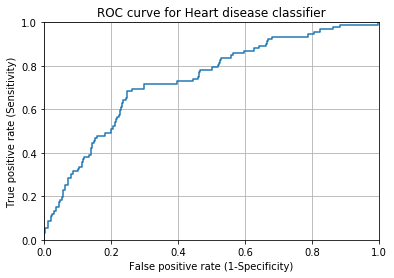

In [25]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_yes[:,1])
plt.plot(fpr,tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for Heart disease classifier')
plt.xlabel('False positive rate (1-Specificity)')
plt.ylabel('True positive rate (Sensitivity)')
plt.grid(True)

A common way to visualize the trade-offs of different thresholds is by using an ROC curve, a plot of the true positive rate (# true positives/ total # positives) versus the false positive rate (# false positives /
total # negatives) for all possible choices of thresholds. A model with good classification accuracy should have significantly more true positives than false positives at all thresholds. 

The optimum position for roc curve is towards the top left corner where the specificity and sensitivity are at optimum levels

### Area Under The Curve (AUC)

The area under the ROC curve quantifies model classification accuracy; the higher the area, the greater the disparity between true and false positives, and the stronger the model in classifying members of the training dataset. An area of 0.5 corresponds to a model that performs no better than random classification and a good classifier stays as far away from that  as possible. An area of 1 is ideal. The closer the AUC to 1 the better.

In [26]:
sklearn.metrics.roc_auc_score(y_test,y_pred_prob_yes[:,1])

0.7355182423962525


## Conclusions:



 - **All attributes selected after the elimination process show Pvalues lower than 5% and thereby suggesting significant role in the Heart disease prediction.** 
<br>
<br>
 - **Men seem to be more susceptible to heart disease than women.Increase in Age,number of cigarettes smoked per day and systolic Blood Pressure also show increasing odds of having heart disease.**
 <br>
 <br>

 - **Total cholesterol shows no significant change in the odds of CHD. This could be due to the presence of 'good cholesterol(HDL) in the total cholesterol reading.Glucose too causes a very negligible change in odds (0.2%).**
 <br>
 <br>

 - **The model predicted with 0.88 accuracy. The model is more specific than sensitive.**
 <br>
 <br>

 - **The Area under the ROC curve is 73.5 which is somewhat satisfactory.**
 <br>
 <br>

 - **Overall model could be improved with more balanced data.**



## Appendix

http://www.who.int/mediacentre/factsheets/fs317/en/

#### Data Source References

https://www.kaggle.com/amanajmera1/framingham-heart-study-dataset/data

